In [20]:
from Gridworld import Gridworld
# Existen 3 modos de juego:
# 'static' <-- Todo inicia en las mismas posiciones predeterminadas
# 'player' <-- Solo el jugador inicia en una posicion aleatoria
# 'random' <-- Todos los objetos inician de forma aleatoria
# size es el tamaño del tablero n x n
game = Gridworld(size=4, mode='static')

In [21]:
# Asi se puede mostrar graficamente el ambiente del juego
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [22]:
# Asi se hace una jugada 
# 'u' <--- arriba
# 'd' <--- abajo
# 'l' <--- izquierda
# 'r' <--- derecha
game.makeMove('d')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', 'P'],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [23]:
# Asi se muestra la recompensa obtenida
# + 10 por ganar '+'
# - 10 por caer al pozo '-'
# -1 por jugada sin ganar
# 'w' es un muro
game.reward()

-1

In [24]:
# Asi se representa el juego
# Cada matriz codifica la posición de uno de los cuatro objetos: 
# el jugador, la portería, el foso y el muro.
game.board.render_np()

array([[[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [25]:
# Es un tensor de forma (4, 4, 4)
game.board.render_np().shape

(4, 4, 4)

In [26]:
import numpy as np
import torch
from Gridworld import Gridworld
import random
from matplotlib import pylab as plt

l1 = 64
l2 = 300
l3 = 400
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3, l4)
)

loss_fn = torch.nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
gamma = 0.9
epsilon = 1.0

In [27]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r'
}

In [38]:
epochs = 2000 
losses = []
for i in range(epochs):  
    game = Gridworld(size=4, mode='static')
    state_ = game.board.render_np().reshape(1, 64) \
             + np.random.rand(1, 64) / 10.0
    state1 = torch.from_numpy(state_).float()
    status = 1
    while (status == 1):
        qval = model(state1)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1, 64) \
                  + np.random.rand(1, 64)/10.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        with torch.no_grad():
            newQ = model(state2.reshape(1, 64))
        maxQ = torch.max(newQ)
        if reward == -1:
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_]
        loss = loss_fn(X, Y)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1:
            status = 0
    if epsilon > 0.1:
        epsilon -= (1/epochs)

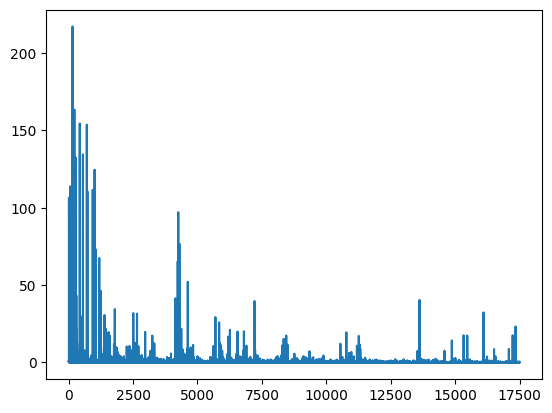

In [29]:
plt.plot(losses);

In [39]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(size = 4, mode = mode)
    state_ = test_game.board.render_np().reshape(1, l1) \
             + np.random.rand(1, l1) / 10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Estado inicial:")
        print(test_game.display())
    status = 1
    while(status == 1):
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_)
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,l1) +\
        np.random.rand(1,l1)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 30):
            if display:
                print("Game lost; too many moves.")
            break
    win = True if status == 2 else False
    return win

In [40]:
test_model(model, 'static')

Estado inicial:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: l
[['+' '-' 'P' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

In [41]:
from collections import deque
epochs = 7000
losses = []
mem_size = 2000
batch_size = 300
replay = deque(maxlen=mem_size)
max_moves = 50 
h = 0 
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1, 64) \
              + np.random.rand(1, 64) / 100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while (status == 1):
        mov += 1
        qval = model(state1)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1, 64) \
                  + np.random.rand(1, 64) / 100
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp = (state1, action_, reward, state2, done)
        replay.append(exp)
        state1 = state2

        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])

            Q1 = model(state1_batch)
            with torch.no_grad():
                Q2 = model(state2_batch)
            
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2, dim=1)[0])
            X =  Q1.gather(
                dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
losses = np.array(losses)

In [42]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print(f"Juegos Jugados: {max_games}, Total de victorias: {wins}")
print(f"Porcentaje de victorias: {win_perc}")

Juegos Jugados: 1000, Total de victorias: 948
Porcentaje de victorias: 0.948


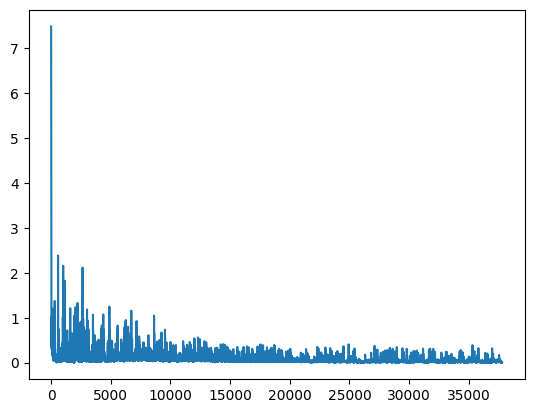

In [43]:
plt.plot(losses);

In [46]:
import copy
from collections import deque


l1 = (8*4*8)
l2 = 300
l3 = 400
l4 = 4


model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3, l4)
)

model2 = copy.deepcopy(model)
model2.load_state_dict(model.state_dict())

loss_fn = torch.nn.MSELoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3
epochs = 1000
losses = []
mem_size = 100
batch_size = 20
replay = deque(maxlen=mem_size)
max_moves = 50
h = 0
sync_freq = 500
j = 0
for i in range(epochs):
    game = Gridworld(size=8, mode='random')
    state1_ = game.board.render_np().reshape(1, l1) \
              + np.random.rand(1, l1)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while (status == 1):
        j += 1
        mov += 1
        qval = model(state1)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1, l1) \
                  + np.random.rand(1, l1)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp = (state1, action_, reward, state2, done)
        replay.append(exp)
        state1 = state2
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            Q1 = model(state1_batch) 
            with torch.no_grad():
                Q2 = model2(state2_batch) #B
            
            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
            if j % sync_freq == 0: #C
                model2.load_state_dict(model.state_dict())
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
        
losses = np.array(losses)


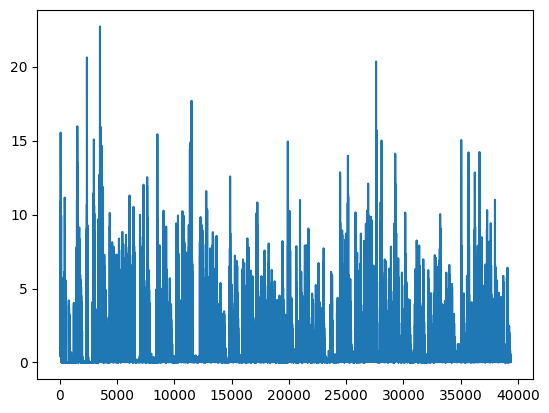

In [47]:
plt.plot(losses);